#  Model Building and Training 

In [68]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
import os, sys
sys.path.append('../scripts')
from eda import *

In [70]:
# Load the datasets
fraud_data = pd.read_csv('../Data/processed_fraud_data.csv')
credit_card_data = pd.read_csv('../Data/processed_creditcard_data.csv')
merged_data = pd.read_csv('../Data/merged_df.csv')

In [71]:
# Apply the conversion function to each column individually
merged_data['purchase_value_binned'] = merged_data['purchase_value_binned'].apply(convert_intervals_to_midpoint)
merged_data['age_binned'] = merged_data['age_binned'].apply(convert_intervals_to_midpoint)

In [72]:
#Feature Selection
X = merged_data.drop('class', axis=1)  # Features
X.drop(columns=['signup_time', 'purchase_time','user_id', 'device_id'], inplace=True)
y = merged_data['class']  # Target variable

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Selection**

In [73]:
# Create a list of models to evaluate
models = [
    ('Random Forest', RandomForestClassifier(random_state=42),
        {'model__n_estimators': [50, 100, 200],
         'model__max_depth': [None, 10, 20]}),  # Add hyperparameters for Random Forest
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42),
        {'model__n_estimators': [50, 100, 200],
         'model__learning_rate': [0.05, 0.1, 0.5]}),  # Add hyperparameters for Gradient Boosting
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'),
        {'model__C': [0.1, 1, 10],
         'model__penalty': ['l1', 'l2']}),  # Add hyperparameters for Logistic Regression
    ('Decision Tree', DecisionTreeClassifier(random_state=42),
        {'model__max_depth': [None, 10, 20],
         'model__min_samples_split': [2, 5, 10]}),  # Add hyperparameters for Decision Tree
]
   

In [74]:
# Initialize an empty list to store model scores
model_scores = []
best_model = None
best_accuracy = 0.0

In [75]:
# Start MLflow experiment
mlflow.set_experiment("Model_Comparison")

<Experiment: artifact_location='file:///c:/Users/USER/Desktop/KAIM/Adey-Innovations-Fraud-Detection/notebook/mlruns/368482420928789429', creation_time=1739098074171, experiment_id='368482420928789429', last_update_time=1739098074171, lifecycle_stage='active', name='Model_Comparison', tags={}>

In [76]:
best_model = None
best_accuracy = 0.0

# Iterate over the models and evaluate their performance
for name, model, param_grid in models:
    # Create a pipeline for each model
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Feature Scaling
        ('model', model)
    ])

    # Hyperparameter tuning using GridSearchCV
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=2)
        grid_search.fit(X_train, y_train)
        pipeline = grid_search.best_estimator_

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append model name and performance metrics to the list
    model_scores.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    # Convert the list to a DataFrame
    scores_df = pd.DataFrame(model_scores)

    # Print the performance metrics
    print("Model:", name)
    print("Test Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()


    # Check if the current model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

# Retrieve the overall best model
print("Best Model:")
print("Test Accuracy:", best_accuracy)
print("Model Pipeline:", best_model, "with accuracy", best_accuracy, "%")
     

Model: Random Forest
Test Accuracy: 0.954084397986837
Precision: 0.9537868739317389
Recall: 0.954084397986837
F1 Score: 0.948228375229709

Model: Gradient Boosting
Test Accuracy: 0.9412311265969803
Precision: 0.9360557159263074
Recall: 0.9412311265969803
F1 Score: 0.9368700413633834

Model: Logistic Regression
Test Accuracy: 0.7180797522260937
Precision: 0.8849526402493375
Recall: 0.7180797522260937
F1 Score: 0.7750292191107724

Model: Decision Tree
Test Accuracy: 0.9439798683701123
Precision: 0.939163556779841
Recall: 0.9439798683701123
F1 Score: 0.938988640765162

Best Model:
Test Accuracy: 0.954084397986837
Model Pipeline: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', RandomForestClassifier(random_state=42))]) with accuracy 0.954084397986837 %


In [77]:
    # Log parameters and metrics to MLflow
mlflow.log_param(f"{name}_best_params", grid_search.best_params_ if param_grid else "None")
mlflow.log_metric(f"{name}_accuracy", accuracy)
mlflow.log_metric(f"{name}_precision", precision)
mlflow.log_metric(f"{name}_recall", recall)
mlflow.log_metric(f"{name}_f1_score", f1)

In [78]:
mlflow.end_run()

In [79]:
# Convert scores to DataFrame
scores_df = pd.DataFrame(model_scores)

C:\Users\USER\AppData\Local\Temp\ipykernel_130836\2922696561.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=scores_df, palette=colors)


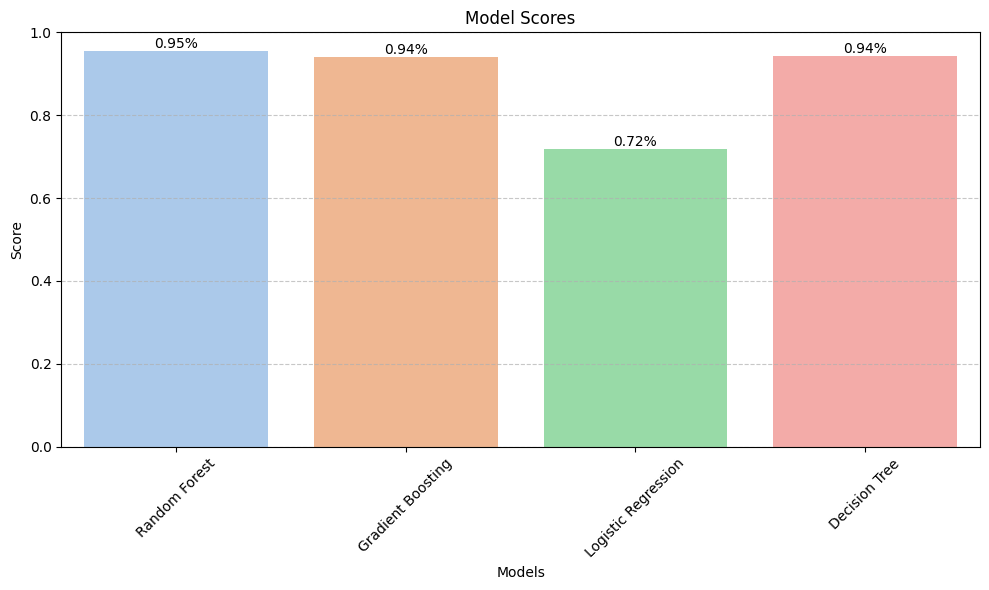

In [80]:
# Define a color palette for the bars
colors = sns.color_palette('pastel', n_colors=len(scores_df))

# Create a bar plot of models and their scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=scores_df, palette=colors)

# Add text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Model Scores')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

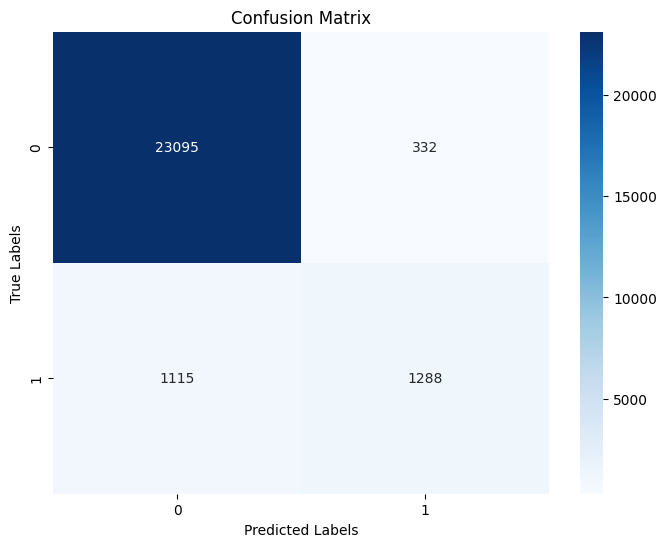

In [81]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Neural Network Model**

Multi-Layer Perceptron (MLP)

In [86]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create an MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=1000, random_state=42)

# Train the model on the training data
mlp.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("MLP Test Accuracy:", accuracy)
print("MLP Precision:", precision)
print("MLP Recall:", recall)
print("MLP F1 Score:", f1)

MLP Test Accuracy: 0.9069686411149825
MLP Precision: 0.8225921159659579
MLP Recall: 0.9069686411149825
MLP F1 Score: 0.8627222265018452


c:\Users\USER\Desktop\KAIM\Adey-Innovations-Fraud-Detection\.myenv8\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, Flatten, Dense
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Assuming you have your dataset in X and y
# Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_reshaped = X_train_cnn.reshape(X_train_cnn.shape[0], -1)  # Flatten
X_test_reshaped = X_test_cnn.reshape(X_test_cnn.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)


def create_cnn():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature Scaling
    ('cnn', KerasClassifier(model=create_cnn, epochs=50, batch_size=32, verbose=0))
])

# Fit the pipeline on the training data
pipeline.fit(X_train_cnn, y_train)

# Make predictions on the test data
y_pred = (pipeline.predict(X_test_cnn) > 0.5).astype(int)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the performance metrics
print("CNN Test Accuracy:", accuracy.round(3))
print("CNN Precision:", precision.round(3))
print("CNN Recall:", recall.round(3))
print("CNN F1 Score:", f1.round(3))

ValueError: Found array with dim 3. StandardScaler expected <= 2.

**RNN**

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the RNN model creation function
def create_rnn():
    model = Sequential()
    model.add(SimpleRNN(64, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the scaler
scaler = StandardScaler()

# Scale the data BEFORE reshaping
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the scaled data to 3D for RNN
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Initialize and fit the KerasClassifier
model = KerasClassifier(model=create_rnn, epochs=50, batch_size=32, verbose=0)
model.fit(X_train_rnn, y_train)

# Make predictions
y_pred = (model.predict(X_test_rnn) > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("RNN Test Accuracy:", accuracy.round(3))
print("RNN Precision:", precision.round(3))
print("RNN Recall:", recall.round(3))
print("RNN F1 Score:", f1.round(3))

c:\Users\USER\Desktop\KAIM\Adey-Innovations-Fraud-Detection\.myenv8\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AttributeError: 'float' object has no attribute 'round'

SHAP

In [99]:
import shap

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [95]:
explainer = shap.KernelExplainer(model.predict, X_train)

NameError: name 'shap' is not defined